<a href="https://colab.research.google.com/github/KelestZ/HighResImg_Gen/blob/master/gcnv2_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import numpy as np
from sklearn.manifold import SpectralEmbedding
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/gdrive/')
import os
os.chdir("/content/gdrive/My Drive/gcn-data/")
!ls

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
sub.label.dat  sub.link.dat  sub.node.dat


In [0]:
import matplotlib.pyplot as plt
import networkx as nx
import copy

def show_graph(adj, thresh=.5):
    if not isinstance(adj, np.ndarray):
        adj_ = adj.data.cpu().numpy()
    else:
        adj_ = copy.deepcopy(adj)
    # adj_ = adj_ / np.max(adj_)
    rows, cols = np.where(adj_ > thresh)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=30)
    plt.show()


def make_adj(x, n):
    res = torch.zeros(n, n).cuda()
    i = 0
    for r in range(1, n):
        for c in range(r, n):
            res[r, c] = x[i]
            res[c, r] = res[r, c]
            i += 1
    return res


def cat_attr(x, attr_vec):
    attr_mat = attr_vec.repeat(x.size()[0], 1)
    x = torch.cat([x, attr_mat], dim=1)
    return x


def get_spectral_embedding(adj, d):
    """
    Given adj is N*N, return its feature mat N*D, D is fixed in model
    :param adj:
    :return:
    """
    adj_ = adj.data.cpu().numpy()
    emb = SpectralEmbedding(n_components=d)
    res = emb.fit_transform(adj_)
    x = torch.from_numpy(res).float().cuda()
    return x

In [0]:
from pprint import pprint
from collections import defaultdict

NODE_FILE = 'sub.node.dat'
LINK_FILE = 'sub.link.dat'
LABEL_FILE = 'sub.label.dat'

id_to_author = {}
id_to_fv = {}
with open(NODE_FILE, 'r') as f:
    for i, line in enumerate(f):
        cells = line.split('\t')
        if cells[1] == '1':
            id_to_author[i] = cells[0]
            id_to_fv[i] = np.asarray([float(a) for a in cells[-1].split(',')])
all_authors = set(id_to_author.values())
all_ids = set(id_to_author.keys())

sg_to_ids = defaultdict(list)
author_to_id = {v: k for k, v in id_to_author.items()}
with open(LABEL_FILE, 'r') as f:
    for line in f:
        cells = line.rstrip('\n').split('\t')
        if cells[1] == '1' and cells[0] in all_authors:
            sg_to_ids[int(cells[2])].append(author_to_id[cells[0]])
for k, v in sg_to_ids.items():
    v.sort()
    
links = defaultdict(set)
with open(LINK_FILE, 'r') as f:
    for line in f:
        cells = line.rstrip('\n').split('\t')
        from_id = int(cells[0])
        to_id = int(cells[1])
        if from_id in all_ids and to_id in all_ids:
            links[from_id].add(to_id)
print('total links', sum(len(s) for s in links.values()))

adj_mats = []
id_maps = []
author_maps = []
feature_mats = []
M = len(id_to_fv[15055])
for sg, ids in sg_to_ids.items():
    N = len(ids)
    cur_ids = set(ids)
    adj_mat = np.zeros((N, N))
    feature_mat = np.zeros((N, M))
    row_map = {id: i for i, id in enumerate(ids)}
    for id in ids:
        for to_id in links[id]:
            if to_id not in cur_ids:
                continue
            r = row_map[id]
            c = row_map[to_id]
            adj_mat[r, c] = 1
            adj_mat[c, r] = 1
            feature_mat[r, :] = id_to_fv[id]
    adj_mats.append(adj_mat)
    id_maps.append(ids)
    author_maps.append([id_to_author[id] for id in ids])
    feature_mats.append(feature_mat)

for i in range(len(adj_mats)):
    print('Sub Group:', i)
    print('Adj Mat', adj_mats[i].shape)
    # print(adj_mats[i])
    # print('Feature Mat', feature_mats[i].shape)
    # print(feature_mats[i])
    # print('# of nodes %d, # of links %d'%(len(id_maps[i]),np.count_nonzero(adj_mats[i]) // 2))
    # print('Author IDs', id_maps[i])
    # print('Author Names', author_maps[i])

t_adj_mats = [torch.from_numpy(m).float() for m in adj_mats]
t_attr_vecs = torch.eye(len(adj_mats))

for i in range(13):
    #print(t_attr_vecs[i])
    print('Graph ID %d: '%i)
    a = t_adj_mats[i]
    show_graph(a)

In [0]:
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [0]:
class Encoder(nn.Module):
    def __init__(self, av_size, d_size, gc_size, z_size, rep_size=32):
        """
        :param av_size: D_A
        :param d_size: D_X
        :param gc_size: D'
        :param z_size: z
        """
        super(Encoder, self).__init__()
        # input parameters
        self.z_size = z_size
        self.attr_vec = None
        self.gc_size = gc_size
        self.d_size = d_size
        self.av_size = av_size
        self.rep_size = rep_size
        
        self.gc = GraphConvolution(d_size , gc_size) #+ av_size
        self.linear = nn.Sequential(
            nn.Linear( gc_size, int(self.rep_size)),
            #nn.BatchNorm1d(int(self.rep_size)),
            nn.ReLU())
        
        self.mean = nn.Sequential(
            nn.Linear( self.rep_size,z_size))

        self.logvar = nn.Sequential(
            nn.Linear( self.rep_size, z_size))
            #nn.BatchNorm1d(self.rep_size),
            #nn.ReLU(),
            #nn.Linear( self.rep_size, z_size))
    
    def set_attr_vec(self, attr_vec):
        self.attr_vec = attr_vec

    def forward(self, adj):
        x = get_spectral_embedding(adj, d=self.d_size)
        # x = cat_attr(x, self.attr_vec)
        x =F.relu(self.gc(x, adj)) # F.relu()
        # x = F.dropout(x, p=0.5)
        x = self.linear(x)
        #x = x.sum(0)
        z_mean = self.mean(x)
        z_logvar = self.logvar(x)

        return z_mean, z_logvar

In [0]:

class Decoder(nn.Module):
    def __init__(self, z_out_size, rep_size=32):
        """
        :param z_out_size: = z_size + len(attr_vec)
        """
        super(Decoder, self).__init__()
        self.z_out_size = z_out_size
        self.rep_size = rep_size
        
        self.decode = nn.Sequential(
            #nn.Linear(z_out_size, self.rep_size),
            #nn.BatchNorm1d(self.rep_size),
            #nn.ReLU(),
            nn.Linear(z_out_size, int(self.rep_size)),
            nn.BatchNorm1d(int(self.rep_size)),
            nn.ReLU(),
            nn.Linear(int(self.rep_size), int(self.rep_size/2)),
            #nn.BatchNorm1d(int(self.rep_size/2)),
            nn.ReLU()
            )#nn.BatchNorm1d(int(self.rep_size/4)),

    def forward(self, z):
      
        x = self.decode(z)

        x = torch.mm(x, x.t())
        x = F.tanh(x)
        return x

In [0]:
class Generator(nn.Module):
    def __init__(self, av_size, d_size, gc_size, z_size, z_out_size, rep_size):
        """
        :param av_size: D_A
        :param d_size: D_X
        :param gc_size: D' = GCN(D_X + D_A)
        :param z_size: original z size
        :param z_out_size: z size + D_A (append attribute)
        """
        super(Generator, self).__init__()
        self.attr_vec = None
        self.av_size = av_size
        self.d_zize = d_size
        self.z_size = z_size
        self.z_out_size = z_out_size
        self.rep_size = rep_size
        self.encoder = Encoder(av_size, d_size, gc_size, z_size, self.rep_size)
        self.decoder = Decoder(z_out_size, self.rep_size)
    
    def set_attr_vec(self, attr_vec):
        self.attr_vec = attr_vec
        self.encoder.set_attr_vec(attr_vec)
   
    def forward(self, adj):
        mean, logvar = self.encoder(adj)

        std = logvar.mul(0.5).exp_()
        reparametrized_noise = torch.randn(mean.shape, requires_grad=True).cuda()
        reparametrized_noise = mean + std * reparametrized_noise
        #x = cat_attr(reparametrized_noise, self.attr_vec)
        
        x = reparametrized_noise
       
        rec_x = self.decoder(x)
        return mean, logvar, rec_x

In [0]:
class Discriminator(nn.Module):
    def __init__(self, av_size, d_size, gc_size, rep_size):
        super(Discriminator, self).__init__()
        self.av_size = av_size
        self.attr_vec = None
        self.d_size = d_size
        self.gc_size = gc_size
        self.rep_size = rep_size
        self.gc = GraphConvolution(d_size , gc_size)#+ av_size
      
        self.main = nn.Sequential(
            #nn.Linear(gc_size, self.rep_size),
            #nn.LeakyReLU(0.2),
            nn.Linear(gc_size, int(self.rep_size)),
            nn.LeakyReLU(0.2),
            nn.Linear(int(self.rep_size), int(self.rep_size/2)),
            nn.LeakyReLU(0.2))
        
        
        self.sigmoid_output = nn.Sequential(
            nn.Linear(int(self.rep_size/2), 1),
            nn.Sigmoid())
    
    def set_attr_vec(self, attr_vec):
        self.attr_vec = attr_vec

    def forward(self, adj):
        # get spectral embedding with adj, D = D_X
        x = get_spectral_embedding(adj, d=self.d_size)
        #x = cat_attr(x, self.attr_vec)
        x = F.relu(self.gc(x, adj))
        # x = F.dropout(x, p=0.5)
        x = self.main(x)
        x = x.sum(0) # only a vector
        x = self.sigmoid_output(x)

        return x

    def similarity(self, adj):
        # get spectral embedding with adj, D = D_X
        x = get_spectral_embedding(adj, d=self.d_size)
        #x = cat_attr(x, self.attr_vec)
        x = F.relu(self.gc(x, adj))
        # x = F.dropout(x, p=0.5)
        # x = x.sum(0)
        x = self.main(x)
        return x

Show rec_adj of 8


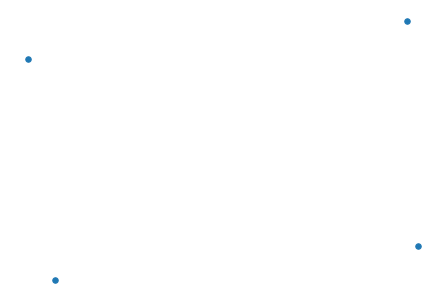

[0/3000]: D_real:0.0198, D_enc:0.0203, D_noise:0.0179, Loss_D:3.9627, Loss_G:-3.8140, rec_loss:0.0003, prior_loss:0.6563
Show rec_adj of 8


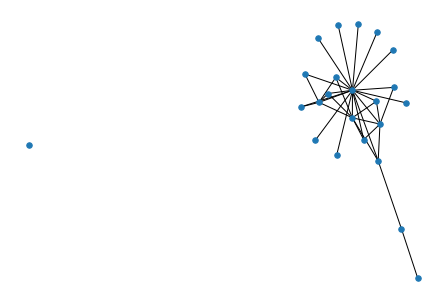

[50/3000]: D_real:0.1235, D_enc:0.1095, D_noise:0.0707, Loss_D:2.2811, Loss_G:-2.2873, rec_loss:0.0005, prior_loss:0.3746
Show rec_adj of 8


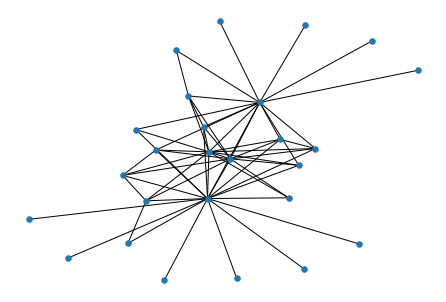

[100/3000]: D_real:0.2358, D_enc:0.1763, D_noise:0.1767, Loss_D:1.8330, Loss_G:-1.8276, rec_loss:0.0003, prior_loss:0.3003
Show rec_adj of 8


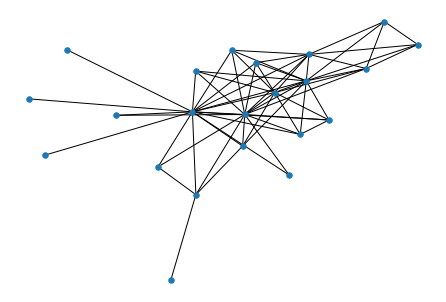

[150/3000]: D_real:0.3253, D_enc:0.1924, D_noise:0.2141, Loss_D:1.5776, Loss_G:-1.5741, rec_loss:0.0004, prior_loss:0.2630
Show rec_adj of 8


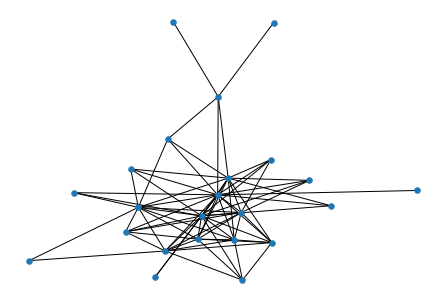

[200/3000]: D_real:0.3780, D_enc:0.3216, D_noise:0.3376, Loss_D:1.7728, Loss_G:-1.7646, rec_loss:0.0003, prior_loss:0.2480
Show rec_adj of 8


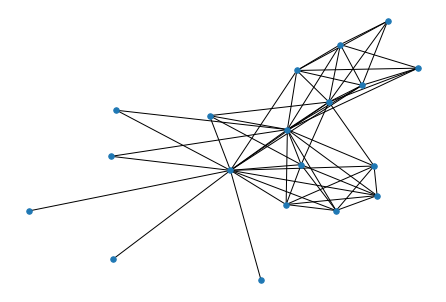

[250/3000]: D_real:0.4038, D_enc:0.3321, D_noise:0.2256, Loss_D:1.5660, Loss_G:-1.5650, rec_loss:0.0003, prior_loss:0.2440
Show rec_adj of 8


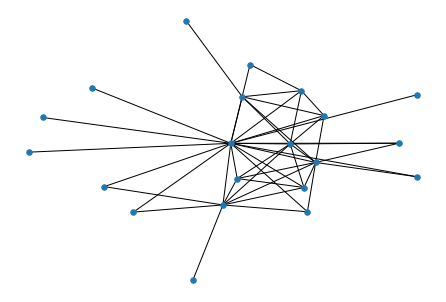

[300/3000]: D_real:0.4109, D_enc:0.3152, D_noise:0.2822, Loss_D:1.5995, Loss_G:-1.5980, rec_loss:0.0003, prior_loss:0.2389
Show rec_adj of 8


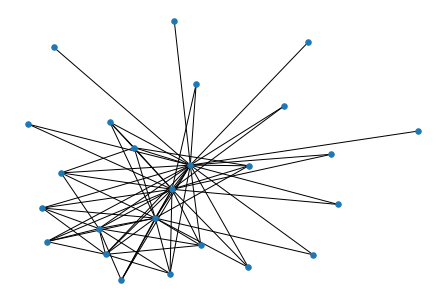

[350/3000]: D_real:0.4239, D_enc:0.3958, D_noise:0.2308, Loss_D:1.6244, Loss_G:-1.6228, rec_loss:0.0003, prior_loss:0.2377
Show rec_adj of 8


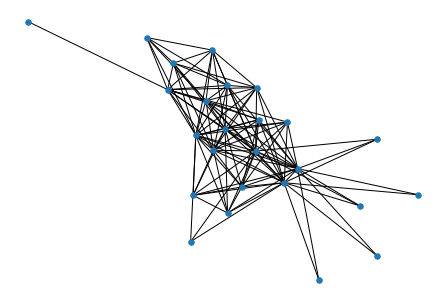

[400/3000]: D_real:0.4313, D_enc:0.2871, D_noise:0.1724, Loss_D:1.3686, Loss_G:-1.3665, rec_loss:0.0005, prior_loss:0.2459
Show rec_adj of 8


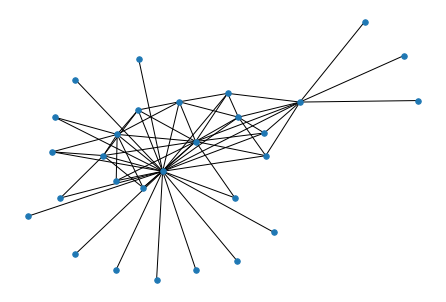

[450/3000]: D_real:0.4454, D_enc:0.2262, D_noise:0.2854, Loss_D:1.4013, Loss_G:-1.3998, rec_loss:0.0006, prior_loss:0.2605
Show rec_adj of 8


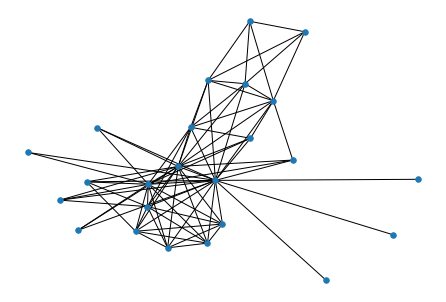

[500/3000]: D_real:0.4655, D_enc:0.1869, D_noise:0.3056, Loss_D:1.3361, Loss_G:-1.2642, rec_loss:0.0006, prior_loss:0.2852
Show rec_adj of 8


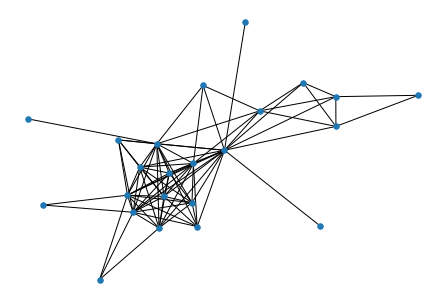

[550/3000]: D_real:0.4676, D_enc:0.2992, D_noise:0.2664, Loss_D:1.4256, Loss_G:-1.4233, rec_loss:0.0006, prior_loss:0.3247
Show rec_adj of 8


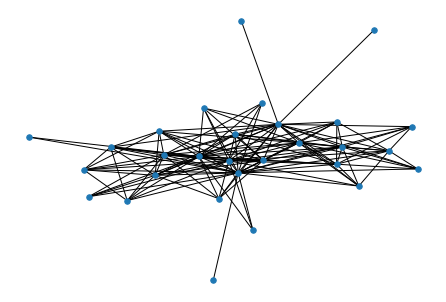

[600/3000]: D_real:0.4844, D_enc:0.3856, D_noise:0.2364, Loss_D:1.4817, Loss_G:-1.4787, rec_loss:0.0005, prior_loss:0.3739
Show rec_adj of 8


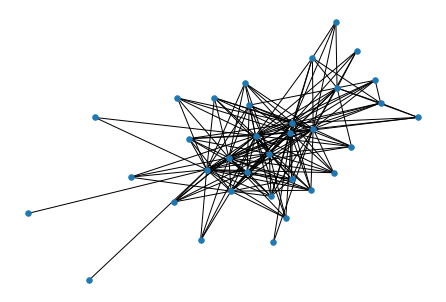

[650/3000]: D_real:0.4888, D_enc:0.1286, D_noise:0.1186, Loss_D:0.9797, Loss_G:-0.9727, rec_loss:0.0010, prior_loss:0.4129
Show rec_adj of 8


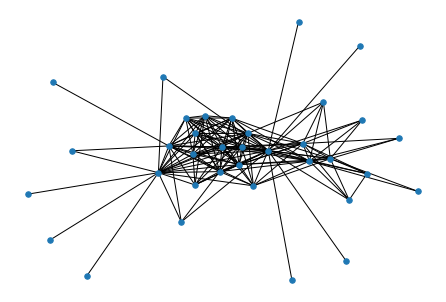

[700/3000]: D_real:0.5138, D_enc:0.4273, D_noise:0.1644, Loss_D:1.4031, Loss_G:-1.4008, rec_loss:0.0006, prior_loss:0.4962
Show rec_adj of 8


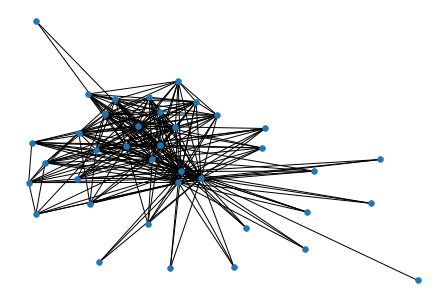

[750/3000]: D_real:0.5258, D_enc:0.1388, D_noise:0.4799, Loss_D:1.4461, Loss_G:-1.4432, rec_loss:0.0011, prior_loss:0.5475


In [0]:
av_size =13
d_size = 16
z_size = 32
gc_size = 16
z_out_size = z_size #+ av_size
adj_thresh = .6
max_epochs = 3000
lr = 3e-4

rep_size = 32
beta = 5
alpha = 0.1
gamma = 15

G = Generator(av_size=av_size, d_size=d_size, gc_size=gc_size, z_size=z_size, z_out_size=z_out_size, rep_size=rep_size).cuda()
D = Discriminator(av_size=av_size, d_size=d_size, gc_size=gc_size, rep_size=rep_size).cuda()

criterion = nn.BCELoss()
criterion.cuda()

opt_enc = optim.RMSprop(G.encoder.parameters(), lr=lr)
opt_dec = optim.RMSprop(G.decoder.parameters(), lr=lr)
opt_dis = optim.RMSprop(D.parameters(), lr=lr * alpha)


for epoch in range(max_epochs):
    D_real_list, D_rec_enc_list, D_rec_noise_list, D_list = [], [], [], []
    g_loss_list, rec_loss_list, prior_loss_list = [], [], []
    # for i in range(len(t_adj_mats)):
    i=8
    ones_label = Variable(torch.ones(1)).cuda()
    zeros_label = Variable(torch.zeros(1)).cuda()

    adj = Variable(t_adj_mats[i]).cuda()
    if adj.shape[0] <= d_size:
        continue
    attr_vec = Variable(t_attr_vecs[i, :]).cuda()

    G.set_attr_vec(attr_vec)
    D.set_attr_vec(attr_vec)

    mean, logvar, rec_adj = G(adj)

    # print ("The size of rec_enc:", rec_adj.size())

    noisev = torch.randn(mean.shape, requires_grad=True).cuda()
    #noisev = cat_attr(noisev, attr_vec)
    rec_noise = G.decoder(noisev)

    # train discriminator
    output = D(adj)
    errD_real = criterion(output, ones_label)
    D_real_list.append(output.data.mean())
    output = D(rec_adj)
    errD_rec_enc = criterion(output, zeros_label)
    D_rec_enc_list.append(output.data.mean())
    output = D(rec_noise)
    errD_rec_noise = criterion(output, zeros_label)
    D_rec_noise_list.append(output.data.mean())

    dis_img_loss = errD_real + errD_rec_enc + errD_rec_noise

    D_list.append(dis_img_loss.data.mean())
    opt_dis.zero_grad()
    dis_img_loss.backward(retain_graph=True)
    opt_dis.step()

    # train decoder
    output = D(adj)
    errD_real = criterion(output, ones_label)
    output = D(rec_adj)
    errD_rec_enc = criterion(output, zeros_label)
    output = D(rec_noise)
    errD_rec_noise = criterion(output, zeros_label)

    similarity_rec_enc = D.similarity(rec_adj)
    similarity_data = D.similarity(adj)

    dis_img_loss = errD_real + errD_rec_enc + errD_rec_noise
    # print (dis_img_loss)
    gen_img_loss = - dis_img_loss

    g_loss_list.append(gen_img_loss.data.mean())
    rec_loss = ((similarity_rec_enc - similarity_data) ** 2).mean()
    rec_loss_list.append(rec_loss.data.mean())
    err_dec = gamma * rec_loss + gen_img_loss

    opt_dec.zero_grad()
    err_dec.backward(retain_graph=True)
    opt_dec.step()

    # train encoder
    # fix me: sum version of prior loss
    pl = []
    
    for j in range(mean.size()[0]):
        prior_loss = 1 + logvar[j, :] - mean[j, :].pow(2) - logvar[j, :].exp()
        prior_loss = (-0.5 * torch.sum(prior_loss))/torch.numel(mean[j, :].data)
        pl.append(prior_loss.mean())
    #print(pl)
    prior_loss_list.append(sum(pl))
    err_enc = 0.001*prior_loss + beta * rec_loss

    opt_enc.zero_grad()
    err_enc.backward()
    opt_enc.step()
    
    if epoch%50 == 0: #and i == 8:
        # print(rec_adj)
        print('Show rec_adj of %d'%i)
        show_graph(rec_adj, thresh=adj_thresh)

        print('[%d/%d]: D_real:%.4f, D_enc:%.4f, D_noise:%.4f, Loss_D:%.4f, Loss_G:%.4f, rec_loss:%.4f, prior_loss:%.4f' 
               % (epoch, 
                  max_epochs, 
                  torch.mean(torch.stack(D_real_list)), 
                  torch.mean(torch.stack(D_rec_enc_list)), 
                  torch.mean(torch.stack(D_rec_noise_list)), 
                  torch.mean(torch.stack(D_list)), 
                  torch.mean(torch.stack(g_loss_list)),
                  torch.mean(torch.stack(rec_loss_list)),
                  torch.mean(torch.stack(prior_loss_list))))
